In [113]:
#import modules
#!pip install nltk

import pandas as pd
import io
import re
import nltk
import pickle
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize, wordpunct_tokenize,RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics #accuracy calculation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [114]:
#load data

df = pd.read_csv("C:/Users/Rachel/Downloads/ml_data/reddit_train.csv", encoding = 'latin1')

In [115]:
#Data Processing
#Convert comments to tokens
df['BodyParsed'] = df['BODY'].str.replace("\r", " ")
df['BodyParsed'] = df['BodyParsed'].str.replace("\n", " ")
df['BodyParsed'] = df['BodyParsed'].str.replace('"', '')
df['BodyParsed'] = df['BodyParsed'].str.lower()
punctuation_signs = list("?:!.,;*()-")
df['BodyParsed'] = df['BodyParsed']
for punct_sign in punctuation_signs:
    df['BodyParsed'] = df["BodyParsed"].str.replace(punct_sign, '')
df['BodyParsed'] = df['BodyParsed'].str.replace("'s", " ")
df['BodyParsed'] = df['BodyParsed'].str.replace("    ", " ")
df.loc[1]['BodyParsed']

'the problem i have with this is that the article appears to credit the plain packets with the decline in smoking  between 2010 and 2013 the proportion of daily smokers in australia dropped from 151 to 128 per cent  a record decline in other words a drop of 23 percent 151  128  yet in the united states  which does not have plain packaging  the rate dropped from 193 in 2010 to 178 in 2013 that  15 percent 193  178 granted that  not as much as australia  decline but it indicates that you cannot credit australia  entire decline to the plain packaging since declines happened in places without plain packaging '

In [116]:
wordnet_lemmatizer = WordNetLemmatizer()
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['BodyParsed']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)
df['BodyParsed'] = lemmatized_text_list
df.loc[1]['BodyParsed']

'the problem i have with this be that the article appear to credit the plain packets with the decline in smoke  between 2010 and 2013 the proportion of daily smokers in australia drop from 151 to 128 per cent  a record decline in other word a drop of 23 percent 151  128  yet in the unite state  which do not have plain package  the rate drop from 193 in 2010 to 178 in 2013 that  15 percent 193  178 grant that  not as much as australia  decline but it indicate that you cannot credit australia  entire decline to the plain package since decline happen in place without plain package '

In [117]:
stop_words = stopwords.words("english")
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['BodyParsed'] = df['BodyParsed'].str.replace(regex_stopword,'')
df.loc[1]['BodyParsed']

' problem        article appear  credit  plain packets   decline  smoke   2010  2013  proportion  daily smokers  australia drop  151  128 per cent   record decline   word  drop  23 percent 151  128  yet   unite state      plain package   rate drop  193  2010  178  2013   15 percent 193  178 grant     much  australia  decline   indicate   cannot credit australia  entire decline   plain package since decline happen  place without plain package '

In [118]:
df['BodyParsed'] = df['BodyParsed'].fillna("").map(word_tokenize)
df['Frequency'] = df['BodyParsed'].map(FreqDist)
df.head()

,Unnamed: 0,X,BODY,REMOVED,BodyParsed,Frequency
0,8756,8877,Always be wary of news articles that cite unpu...,0,"[always, wary, news, article, cite, unpublishe...","{'always': 1, 'wary': 1, 'news': 1, 'article':..."
1,7330,7432,The problem I have with this is that the artic...,0,"[problem, article, appear, credit, plain, pack...","{'problem': 1, 'article': 1, 'appear': 1, 'cre..."
2,15711,15944,"This is indicative of a typical power law, and...",0,"[indicative, typical, power, law, find, number...","{'indicative': 1, 'typical': 1, 'power': 1, 'l..."
3,1604,1625,This doesn't make sense. Chess obviously trans...,0,"[', make, sense, chess, obviously, translate, ...","{''': 3, 'make': 2, 'sense': 1, 'chess': 9, 'o..."
4,13327,13520,1. I dispute that gene engineering is burdenso...,0,"[1, dispute, gene, engineer, burdensome, espec...","{'1': 1, 'dispute': 1, 'gene': 2, 'engineer': ..."


In [119]:
#Train - test split
X_train, X_test, y_train, y_test = train_test_split(df['BodyParsed'],
                                                   df['REMOVED'],
                                                   test_size = 0.10)

In [120]:
X_train = [y for x in X_train.tolist() for y in x]
X_test = [y for x in X_test.tolist() for y in x]


In [121]:
#Using TF-IDF as features

#Parameter election
ngram_range = (1,2) #Consider both unigram and bigrams
min_df = 10 #Ignore terms that have a document frequency strictly lower than the given threshold
max_df = 1. #Ignore terms that have a document frequency strictly higher than this threshold. (1.0 means entire document)
max_features = 300  #If not None, build a vocabulary that only consider teh top max_features ordered by term frequency

In [122]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        preprocessor = ' '.join,
                        sublinear_tf=True)

features_train = tfidf.fit_transform(X_train)#.toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [123]:
#Saving files
# X_train
with open('C:/Users/Rachel/Downloads/ml_data/Pickles/X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
# X_test    
with open('C:/Users/Rachel/Downloads/ml_data/Pickles/X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open('C:/Users/Rachel/Downloads/ml_data/Pickles/y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('C:/Users/Rachel/Downloads/ml_data/Pickles/y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# df
with open('C:/Users/Rachel/Downloads/ml_data/Pickles/df.pickle', 'wb') as output:
    pickle.dump(df, output)
    
# features_train
with open('C:/Users/Rachel/Downloads/ml_data/Pickles/features_train.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('C:/Users/Rachel/Downloads/ml_data/Pickles/labels_train.pickle', 'wb') as output:
    pickle.dump(labels_train, output)

# features_test
with open('C:/Users/Rachel/Downloads/ml_data/Pickles/features_test.pickle', 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open('C:/Users/Rachel/Downloads/ml_data/Pickles/labels_test.pickle', 'wb') as output:
    pickle.dump(labels_test, output)
    
# TF-IDF object
with open('C:/Users/Rachel/Downloads/ml_data/Pickles/tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf, output)

In [124]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [125]:
# Dataframe
path_df = "C:/Users/Rachel/Downloads/ml_data/Pickles/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "C:/Users/Rachel/Downloads/ml_data/Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "C:/Users/Rachel/Downloads/ml_data/Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "C:/Users/Rachel/Downloads/ml_data/Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "C:/Users/Rachel/Downloads/ml_data/Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [126]:
print(features_train.shape)
print(features_test.shape)

(19202, 300)
(2134, 300)


In [127]:
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [128]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial','ovr']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial', 'ovr'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [129]:

# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   14.8s finished


RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=8),
                   n_iter=50,
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0],
                                        'class_weight': ['balanced', None],
                                        'multi_class': ['multinomial', 'ovr'],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'sag', 'saga',
                                                   'lbfgs']},
                   random_state=8, scoring='accuracy', verbose=1)

In [130]:
random_search.cv_results_

{'mean_fit_time': array([0.15, 0.16, 0.2 , 0.08, 0.08, 0.07, 0.07, 0.16, 0.07, 0.11, 0.06,
        0.09, 0.08, 0.13, 0.07, 0.04, 0.05, 0.09, 0.08, 0.09, 0.15, 0.06,
        0.05, 0.07, 0.14, 0.07, 0.08, 0.09, 0.11, 0.18, 0.13, 0.16, 0.12,
        0.09, 0.05, 0.09, 0.09, 0.08, 0.07, 0.14, 0.13, 0.07, 0.19, 0.07,
        0.06, 0.11, 0.07, 0.07, 0.09, 0.07]),
 'std_fit_time': array([0.13, 0.09, 0.03, 0.  , 0.01, 0.  , 0.  , 0.15, 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  ,
        0.  , 0.  , 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.02, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.  ,
        0.  , 0.  , 0.01, 0.01, 0.  , 0.  ]),
 'mean_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'std_score_time': array([1.42e-05, 4.

In [131]:
resultsDF2 = pd.concat([pd.DataFrame(random_search.cv_results_["params"]),pd.DataFrame(random_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
resultsDF2.groupby(by = ["C"])
print(resultsDF2)

       solver penalty  multi_class class_weight    C  Accuracy
0         sag      l2          ovr     balanced  0.5  0.651234
1   newton-cg      l2          ovr     balanced  0.7  0.650557
2   newton-cg      l2  multinomial     balanced  0.7  0.649724
3         sag      l2  multinomial     balanced  0.4  0.650401
4         sag      l2  multinomial         None  0.4  0.696698
5        saga      l2          ovr     balanced  0.8  0.650453
6   newton-cg      l2          ovr     balanced  0.1  0.650037
7       lbfgs      l2          ovr     balanced  0.9  0.650610
8       lbfgs      l2  multinomial     balanced  0.1  0.651755
9        saga      l2  multinomial         None  0.2  0.697480
10       saga      l2          ovr         None  0.2  0.696073
11  newton-cg      l2          ovr     balanced  0.8  0.650349
12      lbfgs      l2          ovr         None  1.0  0.696594
13      lbfgs      l2  multinomial         None  0.2  0.697375
14        sag      l2  multinomial     balanced  0.2  0

In [24]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'sag', 'penalty': 'l2', 'multi_class': 'ovr', 'class_weight': None, 'C': 0.5}

The mean accuracy of a model with these hyperparameters is:
0.6979483267588398


In [19]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
               'multi_class': ['ovr'],
               'solver': ['newton-cg','sag','lbfgs','saga'],
               'class_weight': [None],
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 44 candidates, totalling 132 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 132 out of 132 | elapsed:    9.0s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=LogisticRegression(random_state=8),
             param_grid={'C': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                               0.9, 1],
                         'class_weight': [None], 'multi_class': ['ovr'],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'sag', 'lbfgs', 'saga']},
             scoring='accuracy', verbose=1)

In [20]:
grid_search.cv_results_

{'mean_fit_time': array([0.05518611, 0.04487991, 0.02360344, 0.06615623, 0.11302678,
        0.04222012, 0.04886953, 0.06017145, 0.07579708, 0.04521211,
        0.05850418, 0.05950761, 0.08179092, 0.04687913, 0.06416186,
        0.05851007, 0.0927527 , 0.05253649, 0.07046223, 0.05917398,
        0.09508816, 0.05086907, 0.07711848, 0.05882819, 0.09275206,
        0.05219388, 0.07347043, 0.06049236, 0.09474881, 0.05119578,
        0.07712754, 0.05917446, 0.09707061, 0.05219332, 0.07978638,
        0.05984004, 0.09841204, 0.05718231, 0.10803612, 0.06150325,
        0.09805822, 0.05617944, 0.09341653, 0.05950658]),
 'std_fit_time': array([2.04868680e-03, 4.53351141e-03, 1.88025521e-03, 6.11157401e-03,
        7.29791837e-03, 1.69520151e-03, 8.12933386e-04, 4.70302724e-04,
        2.15390981e-03, 2.04934416e-03, 3.08585785e-03, 4.70021695e-04,
        1.28259446e-05, 8.35258069e-04, 4.63000950e-03, 1.24413389e-03,
        3.55030531e-03, 4.16453960e-03, 1.23478441e-03, 9.40324334e-04,
     

In [21]:
resultsDF = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
resultsDF.groupby(by = ["C"])
print(resultsDF)

       C class_weight multi_class penalty     solver  Accuracy
0   0.01         None         ovr      l2  newton-cg  0.677082
1   0.01         None         ovr      l2        sag  0.677082
2   0.01         None         ovr      l2      lbfgs  0.677082
3   0.01         None         ovr      l2       saga  0.677082
4   0.10         None         ovr      l2  newton-cg  0.690390
5   0.10         None         ovr      l2        sag  0.690390
6   0.10         None         ovr      l2      lbfgs  0.690390
7   0.10         None         ovr      l2       saga  0.690390
8   0.20         None         ovr      l2  newton-cg  0.695913
9   0.20         None         ovr      l2        sag  0.695913
10  0.20         None         ovr      l2      lbfgs  0.695913
11  0.20         None         ovr      l2       saga  0.695965
12  0.30         None         ovr      l2  newton-cg  0.698806
13  0.30         None         ovr      l2        sag  0.698806
14  0.30         None         ovr      l2      lbfgs  0

In [22]:
resultsDF = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
resultsDF.groupby(by = ["C"])
print(resultsDF)

#print(resultsDF['solver'].unique())
#print(resultsDF['C'].unique())
#for s in resultsDF['C'].unique():
#    if s == 0.1:
#        plt.bar(resultsDF['solver'],resultsDF['Accuracy'],label = ("C =" + str(s)))
#plt.show()

       C class_weight multi_class penalty     solver  Accuracy
0   0.01         None         ovr      l2  newton-cg  0.677082
1   0.01         None         ovr      l2        sag  0.677082
2   0.01         None         ovr      l2      lbfgs  0.677082
3   0.01         None         ovr      l2       saga  0.677082
4   0.10         None         ovr      l2  newton-cg  0.690390
5   0.10         None         ovr      l2        sag  0.690390
6   0.10         None         ovr      l2      lbfgs  0.690390
7   0.10         None         ovr      l2       saga  0.690390
8   0.20         None         ovr      l2  newton-cg  0.695913
9   0.20         None         ovr      l2        sag  0.695913
10  0.20         None         ovr      l2      lbfgs  0.695913
11  0.20         None         ovr      l2       saga  0.695965
12  0.30         None         ovr      l2  newton-cg  0.698806
13  0.30         None         ovr      l2        sag  0.698806
14  0.30         None         ovr      l2      lbfgs  0

In [ ]:
ax = plt.gca()
resultsDF1 = resultsDF[(resultsDF.solver == 'newton-cg')]
resultsDF1.plot(kind='line', x = 'C', y = 'Accuracy', ax = ax, label = "Solver = newton-cg")
resultsDF2 = resultsDF[(resultsDF.solver == 'sag')]
resultsDF2.plot(kind='line', x = 'C', y = 'Accuracy', color = "red", ax = ax, label = "Solver = 1")
resultsDF2 = resultsDF[(resultsDF.solver == 'lbfgs')]
resultsDF2.plot(kind='line', x = 'C', y = 'Accuracy', color = "green", ax = ax, label = "Solver = 10")
resultsDF3 = resultsDF[(resultsDF.solver == 'saga')]
resultsDF3.plot(kind='line', x = 'C', y = 'Accuracy', color = "orange", ax = ax, label = "Solver = 100")
plt.figure()


<Figure size 432x288 with 0 Axes>

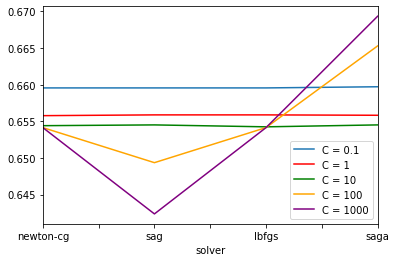

<Figure size 432x288 with 0 Axes>

In [114]:
ax = plt.gca()
resultsDF1 = resultsDF[(resultsDF.C == 0.1)]
resultsDF1.plot(kind='line', x = 'solver', y = 'Accuracy', ax = ax, label = "C = 0.1")
resultsDF2 = resultsDF[(resultsDF.C == 1)]
resultsDF2.plot(kind='line', x = 'solver', y = 'Accuracy', color = "red", ax = ax, label = "C = 1")
resultsDF2 = resultsDF[(resultsDF.C == 10)]
resultsDF2.plot(kind='line', x = 'solver', y = 'Accuracy', color = "green", ax = ax, label = "C = 10")
resultsDF3 = resultsDF[(resultsDF.C == 100)]
resultsDF3.plot(kind='line', x = 'solver', y = 'Accuracy', color = "orange", ax = ax, label = "C = 100")
resultsDF4 = resultsDF[(resultsDF.C == 1000)]
resultsDF4.plot(kind='line', x = 'solver', y = 'Accuracy', color = "purple", ax = ax, label = "C = 1000")
plt.figure()


In [41]:
grid_search

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=LogisticRegression(random_state=8),
             param_grid={'C': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                               0.9, 1],
                         'class_weight': [None], 'multi_class': ['ovr'],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'sag', 'lbfgs', 'saga']},
             scoring='accuracy', verbose=1)

In [48]:
X_test

['long',
 'piece',
 'string',
 'theory',
 'look',
 'survey',
 'closer',
 'see',
 'rat',
 'use',
 'virtually',
 'everything',
 'decrease',
 'age',
 'group',
 '1217alcohol',
 'use',
 'tobacco',
 'use',
 'cocaine',
 'use',
 'marijuana',
 'etc',
 'cursory',
 'glance',
 'actually',
 'look',
 'like',
 'marijuana',
 'use',
 '1217',
 'least',
 'pronounce',
 'decrease',
 'possible',
 'legalization/decriminalization',
 'slow',
 'decrease',
 'utilization',
 'marijuana',
 'possible',
 'legalization',
 'also',
 'decrease',
 'rat',
 'drug',
 'use',
 'older',
 'group',
 'increase',
 'rat',
 'marijuana',
 'possible',
 'survey',
 'underestimate',
 'use',
 'especially',
 'atrisk',
 'youth',
 'data',
 'complex',
 'interpret',
 'number',
 'ways',
 'nuanced',
 'simple',
 '45',
 '%',
 'less',
 '65',
 '%',
 'dead',
 'link',
 'poorly',
 'write',
 'title',
 'bury',
 'time',
 'scale',
 'use',
 'change',
 'improve',
 'standard',
 'live',
 'work',
 'poor',
 'fast',
 'food',
 'sugar',
 'drink',
 'like',
 'cheaper'

In [61]:
from sklearn.metrics import plot_confusion_matrix
X_test_n = np.array(X_test).reshape(300,-1)
matrix = plot_confusion_matrix(best_lrc, X_test_n, y_test)
#,                                 cmap=plt.cm.Blues)
                                 #normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

ValueError: cannot reshape array of size 64470 into shape (300,newaxis)

In [25]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.9, 'class_weight': None, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}

The mean accuracy of a model with these hyperparameters is:
0.7012782073536373


In [26]:
best_lrc = random_search.best_estimator_

In [27]:
best_lrc

LogisticRegression(C=0.5, multi_class='ovr', random_state=8, solver='sag')

In [28]:
best_lrc.fit(features_train, labels_train)

LogisticRegression(C=0.5, multi_class='ovr', random_state=8, solver='sag')

In [29]:
lrc_pred = best_lrc.predict(features_test)

In [30]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))

The training accuracy is: 
0.710655140089574


In [31]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

The test accuracy is: 
0.7019681349578257


In [32]:
# Classification report
print("Classification report")
print(classification_report(labels_test,lrc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.72      0.90      0.80      1426
           1       0.60      0.30      0.40       708

    accuracy                           0.70      2134
   macro avg       0.66      0.60      0.60      2134
weighted avg       0.68      0.70      0.67      2134



In [33]:
base_model = LogisticRegression(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.7057169634489222

In [34]:
best_lrc.fit(features_train, labels_train)
accuracy_score(labels_test, best_lrc.predict(features_test))

0.7019681349578257

In [35]:
d = {
     'Model': 'Logistic Regression',
     'Training Set Accuracy': accuracy_score(labels_train, best_lrc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, lrc_pred)
}

df_models_lrc = pd.DataFrame(d, index=[0])

In [36]:
df_models_lrc

,Model,Training Set Accuracy,Test Set Accuracy
0,Logistic Regression,0.710655,0.701968


In [37]:
with open('C:/Users/Rachel/Downloads/ml_data/Models/best_lrc.pickle', 'wb') as output:
    pickle.dump(best_lrc, output)
    
with open('C:/Users/Rachel/Downloads/ml_data/Models/df_models_lrc.pickle', 'wb') as output:
    pickle.dump(df_models_lrc, output)

Confusion Matrix: [[1285  141]
 [ 495  213]]
AUC Score: 0.600984738631231


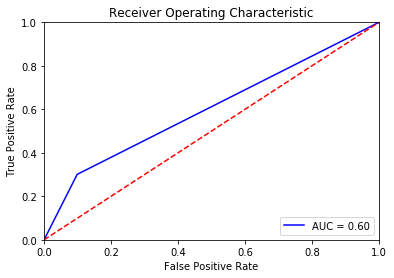

In [87]:
import sklearn.metrics as metrics
#evaluation metrics

#accuracy=best_lrc.score(X_test, y_test)
#print("Accuracy: " + str(accuracy))
conf_matr=metrics.confusion_matrix(labels_test, lrc_pred)
print("Confusion Matrix: " + str(conf_matr))
auc=metrics.roc_auc_score(labels_test, lrc_pred)
print("AUC Score: " + str(auc))
fpr, tpr, threshold = metrics.roc_curve(labels_test, lrc_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [88]:
conf_matr

array([[1285,  141],
       [ 495,  213]], dtype=int64)

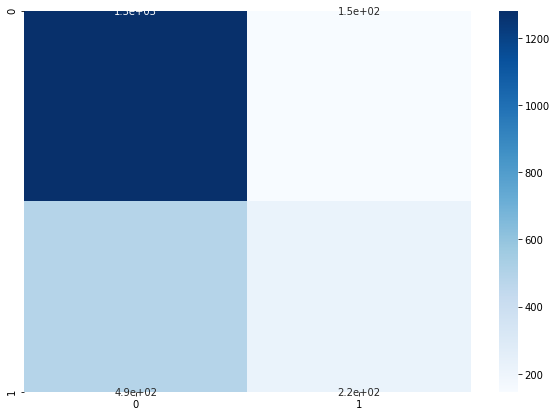

In [46]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[1280,  146],
 [ 489,  219]]
df_cm = pd.DataFrame(array, index = [0,1],
                  columns = [0,1])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, cmap=plt.cm.Blues, annot=True)

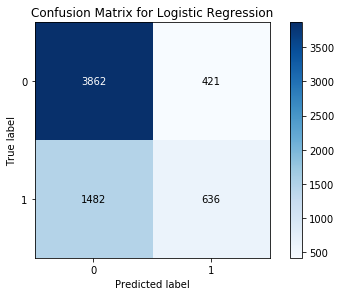

In [106]:
def plot_confusion_matrix2(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = np.array([[3862,  421],
       [ 1482,  636]])
    # Only use the labels that appear in the data
    classes = [0,1]
    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           #title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(1.5, -0.5)


    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.title("Confusion Matrix for Logistic Regression")
    return ax


#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix2(labels_test, lrc_pred, classes = [0,1])

# Plot normalized confusion matrix
#plot_confusion_matrix2(y_test, y_pred, classes=class_names, normalize=True,
                   #   title='Normalized confusion matrix')

plt.show()

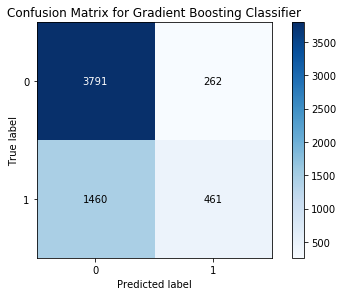

In [112]:
def plot_confusion_matrix2(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = np.array([[3791,  262],
       [ 1460,  461]])
    classes = [0,1]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           #title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(1.5, -0.5)


    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.title("Confusion Matrix for Gradient Boosting Classifier")
    return ax


#np.set_printoptions(precision=2)


plot_confusion_matrix2(labels_test, lrc_pred, classes = [0,1])

# Plot normalized confusion matrix
#plot_confusion_matrix2(y_test, y_pred, classes=class_names, normalize=True,
                   #   title='Normalized confusion matrix')

plt.show()

In [64]:
misclassified_samples = X_test[labels_test != lrc_pred]
ms_df=pd.DataFrame(misclassified_samples)

TypeError: list indices must be integers or slices, not Series

In [30]:
GFG = pd.ExcelWriter("misclassified_ex.xlsx")
ms_df.to_excel(GFG, index = False)

NameError: name 'ms_df' is not defined

In [186]:
GFG.save()

In [161]:
ms_df.iloc[16:21,]

,BodyParsed
10232,"[wow, jama, less, would, someone, please, forw..."
20739,"[interest, things, like, always, phrase, sugge..."
8718,"[fat, oh, right, nobody, food, industry, pay]"
15101,"[picture, atomic, size, bullet, hit, atoms, gr..."
7408,"[wednesday, dudes]"


In [156]:
list(ms_df.index)

[6995,
 2843,
 10549,
 1269,
 738,
 14180,
 1099,
 14552,
 2440,
 13161,
 6405,
 6657,
 6950,
 8075,
 16717,
 20261,
 10232,
 20739,
 8718,
 15101,
 7408,
 4532,
 6214,
 9028,
 11445,
 2198,
 10153,
 8753,
 14770,
 14873,
 5468,
 1061,
 15771,
 3402,
 2569,
 7182,
 16753,
 15193,
 10243,
 8446,
 18352,
 19038,
 11103,
 8360,
 2538,
 9890,
 16929,
 10364,
 5140,
 259,
 20385,
 8944,
 8478,
 6107,
 17548,
 18575,
 3371,
 6478,
 3360,
 8588,
 20139,
 8694,
 1374,
 5882,
 17989,
 15418,
 7576,
 7997,
 18177,
 19497,
 10500,
 20701,
 11308,
 4109,
 3296,
 13867,
 15527,
 507,
 2633,
 20208,
 19450,
 2611,
 6399,
 16759,
 19294,
 1404,
 20824,
 476,
 7661,
 17311,
 809,
 13187,
 920,
 10154,
 7349,
 16288,
 20155,
 14228,
 33,
 4971,
 12347,
 18342,
 13986,
 17856,
 8854,
 15630,
 17586,
 16609,
 4125,
 10783,
 2617,
 18611,
 2315,
 13215,
 4394,
 15188,
 6210,
 1158,
 13502,
 17284,
 11296,
 3239,
 20417,
 5463,
 5845,
 14325,
 6019,
 2805,
 19222,
 20029,
 16039,
 9210,
 16283,
 3385,
 348

In [42]:
X_test.head()

10509    [think, cloud, seed, recognize, document, scie...
8900     [original, apple, come, kazakhstan, accord, st...
17116    [think, funny, reason, name, denisovans, cave,...
20706                            [r/latestagepaleontology]
18005    [drug, veterans, ptsd, likely, abuse, drug, al...
Name: BodyParsed, dtype: object

In [43]:
labels_test

6095     1
19751    0
15109    0
16656    0
238      1
        ..
7059     0
11561    0
9323     0
14479    1
14949    0
Name: REMOVED, Length: 2134, dtype: int64

In [48]:
lrc_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [52]:
labels_test != lrc_pred

6095      True
19751    False
15109    False
16656    False
238       True
         ...  
7059     False
11561    False
9323     False
14479     True
14949    False
Name: REMOVED, Length: 2134, dtype: bool

In [121]:
X_test.head()

21136    [&, gtonly, 14, %, able, guess, within, 1000, ...
12327    [child, 4, year, old, little, girl, short, tim...
16500    [study, show, relation, type, internal, parasi...
12081    [shame, fake, news, phrase, completely, lose, ...
10075    [recent, episode, pbs, program, nova, [, pbs, ...
Name: BodyParsed, dtype: object

In [51]:
X_test[labels_test != lrc_pred]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [58]:
df1 = pd.DataFrame(X_test)
df1.head()

,BodyParsed
10509,"[think, cloud, seed, recognize, document, scie..."
8900,"[original, apple, come, kazakhstan, accord, st..."
17116,"[think, funny, reason, name, denisovans, cave,..."
20706,[r/latestagepaleontology]
18005,"[drug, veterans, ptsd, likely, abuse, drug, al..."


In [149]:
ex1=df1.iloc[0,0]
ex1

['think',
 'cloud',
 'seed',
 'recognize',
 'document',
 'science',
 'already',
 'example',
 'beijing',
 'olympics',
 'open',
 'ceremonies',
 'keep',
 'dry',
 'cloud',
 'seed',
 'rain',
 'upwind']

In [59]:
df2=pd.DataFrame(labels_test != lrc_pred)
df2.head()

,REMOVED
6095,True
19751,False
15109,False
16656,False
238,True


In [125]:
ms_df.head()

,BodyParsed
6995,"[race, social, justice, science, climate, ', d..."
2843,"[make, sense, seem, though, every, girl, think..."
10549,"[ptsd, great, spider/snake, human, war, take, ..."
1269,"[start, notice, place, visit, past, year, volu..."
738,"[&, gt, depictions, intoxication, uncensored, ..."


In [126]:
df.head()

,Unnamed: 0,X,BODY,REMOVED,BodyParsed,Frequency
0,8756,8877,Always be wary of news articles that cite unpu...,0,"[always, wary, news, article, cite, unpublishe...","{'always': 1, 'wary': 1, 'news': 1, 'article':..."
1,7330,7432,The problem I have with this is that the artic...,0,"[problem, article, appear, credit, plain, pack...","{'problem': 1, 'article': 1, 'appear': 1, 'cre..."
2,15711,15944,"This is indicative of a typical power law, and...",0,"[indicative, typical, power, law, find, number...","{'indicative': 1, 'typical': 1, 'power': 1, 'l..."
3,1604,1625,This doesn't make sense. Chess obviously trans...,0,"[', make, sense, chess, obviously, translate, ...","{''': 3, 'make': 2, 'sense': 1, 'chess': 9, 'o..."
4,13327,13520,1. I dispute that gene engineering is burdenso...,0,"[1, dispute, gene, engineer, burdensome, espec...","{'1': 1, 'dispute': 1, 'gene': 2, 'engineer': ..."


In [129]:
df.columns

Index(['Unnamed: 0', 'X', 'BODY', 'REMOVED', 'BodyParsed', 'Frequency'], dtype='object')

In [150]:
df.loc[df['BodyParsed'] == ex1]

ValueError: Lengths must match to compare

In [142]:
list(df.loc[df['X'] == 6995]["BodyParsed"])

[['report',
  'excerpt',
  'text',
  'seem',
  'like',
  '/lot/',
  'swear',
  'hallway',
  'high',
  'school',
  'imply',
  'context',
  'seem',
  'like',
  'right',
  'place',
  'may',
  'study',
  'design',
  'issue',
  'clear',
  'excerpt',
  'share',
  'similarities']]

In [184]:
ms_df.iloc[0:19,0]

6995     [race, social, justice, science, climate, ', d...
2843     [make, sense, seem, though, every, girl, think...
10549    [ptsd, great, spider/snake, human, war, take, ...
1269     [start, notice, place, visit, past, year, volu...
738      [&, gt, depictions, intoxication, uncensored, ...
14180    [use, party, small, house, would, try, go, sle...
1099     [70, %, americans, overweight, obese, 35, %, a...
14552    [could, choose, time, past, bear, ', today, te...
2440                                    [long, hope, pick]
13161    [old, people, ', take, money, go, require, lot...
6405                 [amount, cheese, eat, must, immortal]
6657     [well, brush, teeth, ', particularly, unpleasa...
6950       [', really, tear, dont, know, keep, look, work]
8075     [&, gt1019, american, adults, survey, seem, li...
16717        [two, study, one, benchmarking, shrooms, sex]
20261    [funny, another, political, motivate, weak, as...
10232    [wow, jama, less, would, someone, please, forw.

In [134]:
options.display.max_colwidth

NameError: name 'options' is not defined